In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]


def match_columns(df, target, covariates):
    pos = df[df[target]]
    neg = df[~df[target]]
    D = cdist(pos[covariates], neg[covariates])
    #print(np.min(D, axis=1).max())
    
    # approach 1: has the issue of ties
    #closest = np.argmin(D, axis=1)
    
    # approach 2: greedy, depends on order of snps
    closest = []
    dists = []
    for i in range(len(pos)):
        j = np.argmin(D[i])
        closest.append(j)
        #dists.append(D[i,j])
        D[:, j] = np.inf  # ensure it cannot be picked up again
    #print(max(dists))
    return pd.concat([pos, neg.iloc[closest]])

In [3]:
genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")

Loading MSA...
Loading MSA... Done


In [4]:
from gpn.data import Tokenizer, ReverseComplementer
import gpn.model
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoModelForMaskedLM


class VEPEmbedding(torch.nn.Module):
    def __init__(self, model_path, embedding_mean=None, embedding_std=None):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_path)
        if embedding_mean is not None and embedding_std is not None:
            self.register_buffer("embedding_mean", torch.tensor(embedding_mean))
            self.register_buffer("embedding_std", torch.tensor(embedding_std))
        else:
            self.embedding_mean = None

    def get_embedding(self, input_ids, aux_features, exclude_pos=None):
        embedding = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).last_hidden_state
        
        if exclude_pos is not None:
            embedding = torch.cat((embedding[:, :exclude_pos], embedding[:, exclude_pos+1:]), dim=1)

        # chosing specific layer
        #hidden_states = self.model(
        #    input_ids=input_ids, aux_features=aux_features,
        #    output_hidden_states=True,
        #).hidden_states # note 0 is the encoder, so last layer is 12, not 11
        #embedding = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)  
            
        if self.embedding_mean is not None:
            embedding = (embedding - self.embedding_mean) / self.embedding_std
        
        # this usually on
        embedding = embedding.reshape(len(input_ids), -1)
        
        return embedding
    
    def get_scores(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        embedding_ref = self.get_embedding(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        embedding_alt = self.get_embedding(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        #return torch.stack((embedding_ref, embedding_alt), dim=1)
        return (
            F.pairwise_distance(embedding_ref, embedding_alt),
            (embedding_ref * embedding_alt).sum(dim=1),  # dot product
            F.cosine_similarity(embedding_ref, embedding_alt),
        )

    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]

        #return torch.cat((
        #    self.get_scores(input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd),
        #    self.get_scores(input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev),
        #), dim=1)
        #return res
        fwd1, fwd2, fwd3 = self.get_scores(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            exclude_pos=W//2,
        )
        rev1, rev2, rev3 = self.get_scores(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            exclude_pos=(W//2) - 1,
        )
        #return torch.stack((fwd1, fwd2, fwd3), dim=1)
        #return torch.stack((rev1, rev2, rev3), dim=1)
        return torch.stack((
            (fwd1 + rev1) / 2,
            (fwd2 + rev2) / 2,
            (fwd3 + rev3) / 2,
        
        ), dim=1)


class VEPEmbeddingInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPEmbedding(model_path)#, embedding_mean=embedding_mean, embedding_std=embedding_std)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPEmbeddingInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred


def add_scores(V2):
    V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
    V2.euclidean_distance *= -1
    V2.cosine_similarity -= V2.cosine_similarity.max()
    V2.inner_product -= V2.inner_product.max()
    return V2

In [5]:
def jsd_logits(logits_p, logits_q):
    logprob_p = F.log_softmax(logits_p, dim=2)
    logprob_q = F.log_softmax(logits_q, dim=2)
    return 0.5 * (
        F.kl_div(logprob_p, logprob_q, log_target=True, reduction="none").sum(dim=(1,2)) +
        F.kl_div(logprob_q, logprob_p, log_target=True, reduction="none").sum(dim=(1,2))
    )

class VEPLogits(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_path)

    def get_logits(self, input_ids, aux_features, exclude_pos=None):
        logits = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).logits
        
        if exclude_pos is not None:
            logits = torch.cat((logits[:, :exclude_pos], logits[:, exclude_pos+1:]), dim=1)
        
        return logits
    
    def get_score(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        logits_ref = self.get_logits(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        logits_alt = self.get_logits(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        return jsd_logits(logits_ref, logits_alt)
        
    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]
        fwd = self.get_score(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            exclude_pos=W//2
        )
        rev = self.get_score(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            exclude_pos=(W//2)-1
        )
        return (fwd + rev) / 2
   

class VEPLogitsInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPLogits(model_path)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep_logits(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPLogitsInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred

In [6]:
ldscore = pd.read_parquet("../../results/tmp/ldscore.processed.parquet")
ldscore

,chrom,pos,ref,alt,AF,ld_score
0,1,11063,T,G,0.000048,5.738593
1,1,13259,G,A,0.000278,5.048821
2,1,17641,G,A,0.000831,1.683291
3,1,57222,T,C,0.000659,2.475932
4,1,58396,T,C,0.00024,29.534102
...,...,...,...,...,...,...
22153592,X,155697134,G,A,0.000028,28.358136
22153593,X,155697920,G,A,0.302726,406.085388
22153594,X,155699751,C,T,0.245915,483.126375
22153595,X,155700569,A,G,0.246325,484.684299


In [7]:
ldscore["MAF"] = ldscore['AF'].apply(lambda x: min(x, 1-x))

In [8]:
pips = pd.read_parquet("../../results/tmp/my_pips.parquet")
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [9]:
"""
disease_traits = [
    'AFib',
    'AID_Combined',
    'Alzheimer_LTFH',
    'Asthma',
    'Blood_Clot_Lung',
    'BrC',
    'CAD',
    'Cholelithiasis',
    'CRC',
    'DVT',
    'Fibroblastic_Disorders',
    'Glaucoma_Combined',
    'Hypothyroidism',
    'IBD',
    'Inguinal_Hernia',
    'LOY',
    'MCP',
    'Migraine_Self',
    'PrC',
    'T2D',
    'T2D_BMI',
]

pips = pips[pips.trait.isin(disease_traits)]
pips
"""

"\ndisease_traits = [\n    'AFib',\n    'AID_Combined',\n    'Alzheimer_LTFH',\n    'Asthma',\n    'Blood_Clot_Lung',\n    'BrC',\n    'CAD',\n    'Cholelithiasis',\n    'CRC',\n    'DVT',\n    'Fibroblastic_Disorders',\n    'Glaucoma_Combined',\n    'Hypothyroidism',\n    'IBD',\n    'Inguinal_Hernia',\n    'LOY',\n    'MCP',\n    'Migraine_Self',\n    'PrC',\n    'T2D',\n    'T2D_BMI',\n]\n\npips = pips[pips.trait.isin(disease_traits)]\npips\n"

In [10]:
pips = pips[(~pips.LD_HWE) & (~pips.LD_SV)]
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [11]:
# option 1
pips = pips[pips.method=="SUSIE"]

# option 2
#pips = pips.groupby(["chrom", "pos", "ref", "alt", "trait"]).agg({"method": "nunique", "pip": "mean", "maf": "mean"}).reset_index()
#pips = pips[pips.method==2]

pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [12]:
# option 1
#pips_agg = pips.groupby(cols).agg({"pip": "sum", "maf": "mean", "trait": "count"}).reset_index().rename(columns={"trait": "n_traits"})
#pips_agg["pip"] = pips_agg.pip / len(pips.trait.unique())  # average pip

# option 2
pips_agg = pips.groupby(cols).agg({"pip": "max", "maf": "mean"}).reset_index()

pips_agg

,chrom,pos,ref,alt,pip,maf
0,1,820055,T,G,0.001039,0.005550
1,1,832873,A,C,0.003492,0.236748
2,1,833068,G,A,0.004263,0.106004
3,1,834583,G,A,0.004209,0.105298
4,1,835506,G,A,0.004478,0.104339
...,...,...,...,...,...,...
1632740,9,138172038,C,T,0.001342,0.372683
1632741,9,138173218,G,A,0.045044,0.165755
1632742,9,138174172,T,C,0.001422,0.372984
1632743,9,138174508,T,C,0.001392,0.399574


In [13]:
models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa",
    "CADD.RawScore",
    "phyloP",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa": "GPN-MSA",
}

V = pd.read_parquet("../../results/finemapping/processed/test.parquet")
d = Path(f"../../results/preds/results/finemapping/processed")
for m in models:
    model_name = model_renaming.get(m, m)
    if m in V.columns:
        V.rename(columns={m: model_name}, inplace=True)
        continue
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP
0,1,832873,A,C,0.487101,0.145778,0.677
1,1,833068,G,A,1.751498,0.016390,-0.036
2,1,834583,G,A,0.339468,0.051453,0.479
3,1,835506,G,A,-0.253357,0.177210,0.645
4,1,841852,C,T,0.046023,0.025537,0.459
...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.883718,-0.438139,0.932
1821944,22,50784537,G,A,0.073284,-0.645151,-0.249
1821945,22,50790482,G,A,0.051396,0.020462,-0.349
1821946,22,50791289,A,T,-0.813960,-0.261473,-0.062


In [14]:
V = V.merge(ldscore, on=cols, how="inner")
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF
0,1,832873,A,C,0.487101,0.145778,0.677,0.763689,65.233773,0.236311
1,1,833068,G,A,1.751498,0.016390,-0.036,0.105508,39.035791,0.105508
2,1,834583,G,A,0.339468,0.051453,0.479,0.104803,39.16434,0.104803
3,1,835506,G,A,-0.253357,0.177210,0.645,0.103867,38.977357,0.103867
4,1,841852,C,T,0.046023,0.025537,0.459,0.095105,39.579469,0.095105
...,...,...,...,...,...,...,...,...,...,...
1816798,22,50783624,G,A,-0.883718,-0.438139,0.932,0.299913,38.986375,0.299913
1816799,22,50784537,G,A,0.073284,-0.645151,-0.249,0.30374,39.121952,0.303740
1816800,22,50790482,G,A,0.051396,0.020462,-0.349,0.299102,37.73791,0.299102
1816801,22,50791289,A,T,-0.813960,-0.261473,-0.062,0.295325,37.576431,0.295325


In [15]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [16]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9887593756725412

In [17]:
V = V[not_na]
V.shape

(1796381, 10)

## Aggregate

In [18]:
from scipy.stats import zscore

V2 = V.merge(pips_agg, how="inner", on=cols).sort_values("pip", ascending=False)
V2["maf_z"] = zscore(V2["maf"])
V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))

# option 1
#V2.loc[V2.pip.rank(ascending=False) <= 1000, "Likely causal"] = True   # 1000
#V2.loc[V2.pip.rank() <= 100_000, "Likely causal"] = False  # 100_000

# option 2
V2.loc[V2.pip > 0.99, "Likely causal"] = True
V2.loc[V2.pip < 0.01, "Likely causal"] = False

V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    1248001
True        1460
Name: count, dtype: int64

In [19]:
V2 = match_columns(
    V2, "Likely causal",
    [
        "maf_z",
        "ld_score_z"
    ]
)
V2 = V2.drop_duplicates()
V2["Likely causal"].value_counts()

Likely causal
True     1460
False    1460
Name: count, dtype: int64

In [20]:
V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,1.000000,0.008051,-1.254893,-0.819434,True,35.971123,98259.601562,0.993455
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,1.000000,0.051959,-0.973912,-0.847817,True,26.772373,98461.062500,0.996372
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,1.000000,0.051695,-0.975603,-0.378455,True,8.553123,98969.515625,0.999631
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,1.000000,0.022357,-1.163349,-0.863490,True,7.425867,98981.468750,0.999721
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,1.000000,0.006824,-1.262746,-0.927246,True,21.398685,98645.687500,0.997681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136708,1,234490133,C,G,-3.501112,-0.259817,-0.479,0.067282,20.121107,0.067282,0.003653,0.066970,-0.877855,-0.906660,False,25.392609,98712.617188,0.996744
1319590,16,20975184,C,T,-0.160268,0.396571,0.732,0.456484,143.972223,0.456484,0.001057,0.456755,1.616490,-0.096932,False,13.685951,98845.960938,0.999050
577450,6,402087,T,C,-1.455455,-0.021822,0.342,0.063275,57.37736,0.063275,0.001426,0.062803,-0.904521,-0.663082,False,11.365932,98934.773438,0.999347
1502544,19,38673824,C,T,-0.301022,-0.101097,-0.292,0.484215,196.600375,0.484215,0.007927,0.484662,1.795077,0.247146,False,20.381060,98644.031250,0.997899


In [21]:
models = ["GPN-MSA", "CADD", "phyloP"]

In [22]:
models += ["euclidean_distance", "inner_product", "cosine_similarity"]

In [23]:
V2.euclidean_distance *= -1
V2.cosine_similarity -= V2.cosine_similarity.max()
V2.inner_product -= V2.inner_product.max()
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,1.000000,0.008051,-1.254893,-0.819434,True,-35.971123,-767.117188,-0.006484
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,1.000000,0.051959,-0.973912,-0.847817,True,-26.772373,-565.656250,-0.003568
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,1.000000,0.051695,-0.975603,-0.378455,True,-8.553123,-57.203125,-0.000309
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,1.000000,0.022357,-1.163349,-0.863490,True,-7.425867,-45.250000,-0.000218
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,1.000000,0.006824,-1.262746,-0.927246,True,-21.398685,-381.031250,-0.002258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136708,1,234490133,C,G,-3.501112,-0.259817,-0.479,0.067282,20.121107,0.067282,0.003653,0.066970,-0.877855,-0.906660,False,-25.392609,-314.101562,-0.003196
1319590,16,20975184,C,T,-0.160268,0.396571,0.732,0.456484,143.972223,0.456484,0.001057,0.456755,1.616490,-0.096932,False,-13.685951,-180.757812,-0.000889
577450,6,402087,T,C,-1.455455,-0.021822,0.342,0.063275,57.37736,0.063275,0.001426,0.062803,-0.904521,-0.663082,False,-11.365932,-91.945312,-0.000592
1502544,19,38673824,C,T,-0.301022,-0.101097,-0.292,0.484215,196.600375,0.484215,0.007927,0.484662,1.795077,0.247146,False,-20.381060,-382.687500,-0.002041


In [24]:
#V2["JSD"] = -score_vep_logits(V2)
#models.append("JSD")
#V2

In [25]:
V2[models].corr(method="spearman")

,GPN-MSA,CADD,phyloP,euclidean_distance,inner_product,cosine_similarity
GPN-MSA,1.000000,0.663698,0.630908,0.299866,0.476965,0.302491
CADD,0.663698,1.000000,0.832223,0.294453,0.479792,0.296876
phyloP,0.630908,0.832223,1.000000,0.245206,0.403527,0.247290
euclidean_distance,0.299866,0.294453,0.245206,1.000000,0.882705,0.999957
inner_product,0.476965,0.479792,0.403527,0.882705,1.000000,0.884197
cosine_similarity,0.302491,0.296876,0.247290,0.999957,0.884197,1.000000


In [26]:
def rank_transform(s):
    return -(s.rank(ascending=False))

for m in ["euclidean_distance", "inner_product", "cosine_similarity"]:#, "JSD"]:
    V2[f"rank(LLR)+rank({m})"] = rank_transform(V2["GPN-MSA"]) + rank_transform(V2[m])
    models.append(f"rank(LLR)+rank({m})")
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,...,maf,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity,rank(LLR)+rank(euclidean_distance),rank(LLR)+rank(inner_product),rank(LLR)+rank(cosine_similarity)
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,...,0.008051,-1.254893,-0.819434,True,-35.971123,-767.117188,-0.006484,-5293.0,-5262.0,-5291.0
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,...,0.051959,-0.973912,-0.847817,True,-26.772373,-565.656250,-0.003568,-4658.0,-4607.0,-4654.0
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,...,0.051695,-0.975603,-0.378455,True,-8.553123,-57.203125,-0.000309,-1894.0,-1873.0,-1888.0
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,...,0.022357,-1.163349,-0.863490,True,-7.425867,-45.250000,-0.000218,-1575.0,-1560.0,-1573.0
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,...,0.006824,-1.262746,-0.927246,True,-21.398685,-381.031250,-0.002258,-4466.0,-4496.0,-4461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136708,1,234490133,C,G,-3.501112,-0.259817,-0.479,0.067282,20.121107,0.067282,...,0.066970,-0.877855,-0.906660,False,-25.392609,-314.101562,-0.003196,-4915.0,-4256.0,-4906.0
1319590,16,20975184,C,T,-0.160268,0.396571,0.732,0.456484,143.972223,0.456484,...,0.456755,1.616490,-0.096932,False,-13.685951,-180.757812,-0.000889,-1549.0,-1734.0,-1542.0
577450,6,402087,T,C,-1.455455,-0.021822,0.342,0.063275,57.37736,0.063275,...,0.062803,-0.904521,-0.663082,False,-11.365932,-91.945312,-0.000592,-2445.0,-2453.0,-2442.0
1502544,19,38673824,C,T,-0.301022,-0.101097,-0.292,0.484215,196.600375,0.484215,...,0.484662,1.795077,0.247146,False,-20.381060,-382.687500,-0.002041,-2490.0,-2643.0,-2486.0


In [27]:
#for m in ["euclidean_distance", "inner_product", "cosine_similarity"]:#, "JSD"]:
#    V2[f"LLR*{m}"] = -V2["GPN-MSA"] * V2[m]
#    models.append(f"LLR*{m}")

In [28]:
n = len(V2)//2

results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V2["Likely causal"], -V2[m]),
        average_precision_score(V2["Likely causal"], -V2[m]),
        np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
    ])
results = pd.DataFrame(results, columns=["Model", "AUROC", "AUPRC", "Pairwise_accuracy"])
results

,Model,AUROC,AUPRC,Pairwise_accuracy
0,GPN-MSA,0.680258,0.718099,0.678082
1,CADD,0.693512,0.739981,0.702740
2,phyloP,0.643986,0.691881,0.646575
3,euclidean_distance,0.583677,0.585388,0.588356
4,inner_product,0.657887,0.679862,0.665068
5,cosine_similarity,0.584397,0.586650,0.588356
6,rank(LLR)+rank(euclidean_distance),0.656859,0.672432,0.657534
7,rank(LLR)+rank(inner_product),0.686049,0.718697,0.693151
8,rank(LLR)+rank(cosine_similarity),0.657079,0.672782,0.658219


<Axes: xlabel='Pairwise_accuracy', ylabel='Model'>

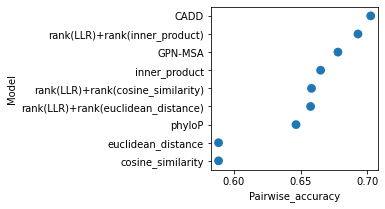

In [29]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("Pairwise_accuracy", ascending=False),
    y="Model",
    x="Pairwise_accuracy",
    join=False,
)

<Axes: xlabel='AUROC', ylabel='Model'>

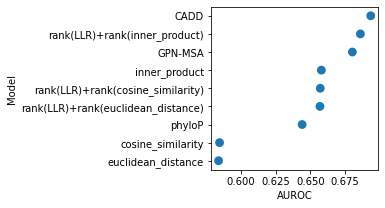

In [30]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False),
    y="Model",
    x="AUROC",
    join=False,
)

## By trait

In [81]:
#traits = pips.trait.value_counts().index.values[:10]
#traits = ["Height"]
traits = pips.trait.unique()
traits

array(['IGF1', 'CRP', 'Plt', 'BW', 'Hb', 'UA', 'Height', 'VitD', 'GGT',
       'TP', 'eGFRcys', 'ApoA', 'SBP', 'BFP', 'eGFR', 'FEV1FVC', 'Ca',
       'eBMD', 'ALP', 'ALT', 'HDLC', 'AG', 'Alb', 'SHBG', 'BMI', 'Eosino',
       'DVT', 'PP', 'MCH', 'MCV', 'Mono', 'Ht', 'MAP', 'WHRadjBMI', 'DBP',
       'Glucose', 'HbA1c', 'RBC', 'Migraine_Self', 'LOY', 'MCHC',
       'Smoking_Ever_Never', 'Neuroticism', 'Morning_Person',
       'Age_at_Menarche', 'Miserableness', 'Worrier', 'Lym', 'WBC',
       'Neutro', 'Balding_Type4', 'AST', 'Inguinal_Hernia', 'Tense', 'TC',
       'ApoB', 'AFib', 'Urea', 'LDLC', 'IBD', 'Baso',
       'Fibroblastic_Disorders', 'TG', 'TBil', 'Testosterone',
       'Risk_Taking', 'Guilty_Feelings', 'Sensitivity', 'AID_Combined',
       'Age_at_Menopause', 'MCP', 'CAD', 'Insomnia', 'Nervous_Feelings',
       'Depression_GP', 'FedUp_Feelings', 'Mood_Swings', 'PrC',
       'Hypothyroidism', 'LipoA', 'Asthma', 'Glaucoma_Combined',
       'Blood_Clot_Lung', 'Alzheimer_LTFH', '

In [82]:
# TODO: should skip datapoints if closest MAF is not small enough

In [83]:
models = ["GPN-MSA", "CADD", "phyloP"]

In [84]:
results2 = []
for trait in tqdm(traits):
    V2 = V.merge(pips[pips.trait==trait], how="inner", on=cols).copy()
    V2["maf_z"] = zscore(V2["maf"])
    V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))
    V2.loc[V2.pip < 0.01, "Likely causal"] = False
    V2.loc[V2.pip >  0.99, "Likely causal"] = True
    V2 = V2.dropna(subset="Likely causal")
    V2["Likely causal"] = V2["Likely causal"].astype(bool)
    n = len(V2)
    if (V2["Likely causal"].sum() < 1) or ((~V2["Likely causal"]).sum() < 1): continue
    V2 = match_columns(V2, "Likely causal", ["maf_z", "ld_score_z"])
    #df = []
    #for i in range(len(V2)//2):
    #    pos, neg = V2.iloc[i], V2.iloc[i+len(V2)//2]
    #    df.append([pos.maf-neg.maf, pos.ld_score-neg.ld_score])
    #df = pd.DataFrame(df, columns=["delta_maf", "delta_ldscore"])
    #V2 = V2.drop_duplicates()
    
    V2 = add_scores(V2)
    models += ["euclidean_distance", "inner_product", "cosine_similarity"]
    for m in ["euclidean_distance", "inner_product", "cosine_similarity"]:
        V2[f"rank(LLR)+rank({m})"] = rank_transform(V2["GPN-MSA"]) + rank_transform(V2[m])
        models.append(f"rank(LLR)+rank({m})")
    
    n_causal = V2["Likely causal"].sum()
    n = n_causal
    for m in models:
        results2.append([
            trait, n_causal, m,
            roc_auc_score(V2["Likely causal"], -V2[m]),
            average_precision_score(V2["Likely causal"], -V2[m]),
            np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
        ])
results2 = pd.DataFrame(results2, columns=["Trait", "n_causal", "Model", "AUROC", "AUPRC", "Pairwise_accuracy"])
results2

  0%|          | 0/94 [00:00<?, ?it/s]

  1%|          | 1/94 [00:05<08:44,  5.64s/it]

  2%|▏         | 2/94 [00:09<07:26,  4.85s/it]

  3%|▎         | 3/94 [00:16<08:29,  5.60s/it]

  4%|▍         | 4/94 [00:20<07:25,  4.95s/it]

  5%|▌         | 5/94 [00:25<07:25,  5.01s/it]

  6%|▋         | 6/94 [00:29<06:52,  4.68s/it]

  7%|▋         | 7/94 [00:35<07:35,  5.24s/it]

  9%|▊         | 8/94 [00:39<06:40,  4.65s/it]

 10%|▉         | 9/94 [00:44<06:47,  4.80s/it]

 11%|█         | 10/94 [00:49<06:46,  4.84s/it]

 12%|█▏        | 11/94 [00:54<06:45,  4.88s/it]

 13%|█▎        | 12/94 [01:00<06:59,  5.12s/it]

 14%|█▍        | 13/94 [01:03<06:23,  4.73s/it]

 15%|█▍        | 14/94 [01:07<05:52,  4.41s/it]

 16%|█▌        | 15/94 [01:12<06:07,  4.65s/it]

 17%|█▋        | 16/94 [01:17<05:57,  4.58s/it]

 18%|█▊        | 17/94 [01:21<05:54,  4.61s/it]

 19%|█▉        | 18/94 [01:30<07:27,  5.89s/it]

 20%|██        | 19/94 [01:37<07:43,  6.18s/it]

 21%|██▏       | 20/94 [01:42<07:07,  5.77s/it]

 22%|██▏       | 21/94 [01:49<07:22,  6.07s/it]

 23%|██▎       | 22/94 [01:55<07:25,  6.18s/it]

 24%|██▍       | 23/94 [02:00<06:59,  5.91s/it]

 26%|██▌       | 24/94 [02:07<07:06,  6.10s/it]

 27%|██▋       | 25/94 [02:11<06:16,  5.46s/it]

 28%|██▊       | 26/94 [02:19<07:04,  6.24s/it]

 29%|██▊       | 27/94 [02:23<06:22,  5.71s/it]

 30%|██▉       | 28/94 [02:28<05:57,  5.42s/it]

 31%|███       | 29/94 [02:37<06:51,  6.33s/it]

 32%|███▏      | 30/94 [02:45<07:27,  6.99s/it]

 33%|███▎      | 31/94 [02:53<07:43,  7.36s/it]

 34%|███▍      | 32/94 [02:59<07:00,  6.79s/it]

 35%|███▌      | 33/94 [03:03<06:02,  5.94s/it]

 36%|███▌      | 34/94 [03:07<05:31,  5.52s/it]

 37%|███▋      | 35/94 [03:12<05:03,  5.14s/it]

 38%|███▊      | 36/94 [03:16<04:42,  4.87s/it]

 39%|███▉      | 37/94 [03:23<05:22,  5.65s/it]

 40%|████      | 38/94 [03:31<05:43,  6.13s/it]

 41%|████▏     | 39/94 [03:34<04:50,  5.29s/it]

 43%|████▎     | 40/94 [03:38<04:26,  4.94s/it]

 43%|████▎     | 40/94 [03:42<05:00,  5.56s/it]


KeyboardInterrupt: 

In [ ]:
results2.groupby("Model").Pairwise_accuracy.agg(["mean", "median"])

In [ ]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results2,
    y="Model",
    x="Pairwise_accuracy",
    join=False,
    errorbar=None,
)

In [ ]:
plt.plot(results2.groupby("Trait").apply(lambda df: df.query('Model == "GPN-MSA"').iloc[0].Pairwise_accuracy - df.query('Model == "CADD"').iloc[0].Pairwise_accuracy))

In [ ]:
plt.plot(results2.groupby("Trait").apply(lambda df: df.query('Model == "rank(LLR)+rank(inner_product)"').iloc[0].Pairwise_accuracy - df.query('Model == "CADD"').iloc[0].Pairwise_accuracy))